# TROPESS H2O Product

This notebook illustrates how to:
- read a TROPESS H$_2$O Standard file
- access the variables in the file
- derive the x_test variable, which guarantees that the averaging kernels are applied correctly. This variable is only derived for the very first retrieved profile.
- plot maps and profiles of H$_2$O

You only need to install 4 Python packages:
- netCDF4
- numpy
- matplotlib
- cartopy

No extra scripts or subroutines are required; the notebook contains all the routines that are needed. Simply compile each individual cell from the top (SHIFT + RETURN keys) or run the whole script at once with the PLAY button.

## Import modules

These are the Python modules you need to import (and install if not available):

In [1]:
# You need to install numpy, netCDF4, matplotlib, and cartopy

# Standard Python modules
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Cartopy functions for plotting
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Suppress the "invalid value encountered" warning
np.seterr(invalid='ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Define all the subroutines we need for this notebook

First, a generic routine to read netCDF4 files:

In [2]:
class _ReadNcObject ():
    ##############
    # Generates an object for read_nc
    #
    # Parameters
    # ---------
    # None
    #
    # Returns
    # -------
    # None
    ##############
    def __init__(self,
                 global_attrs,
                 datasets,
                 values,
                 attributes):

        self.global_attrs = global_attrs
        self.datasets = datasets
        self.values = values
        self.attributes = attributes


def read_nc(file_name='',
            data_sets=None):
    # ========================================================
    # A generic NetCDF reader
    #
    # Parameters
    # ---------
    # file_name : string; name of the h5 file
    # data_sets : string array; an array of group names to be read
    #
    # Returns
    # -------
    # _ReadNcObject : arrays and 2 dictionaries containing the names of datasets, values and information
    # ========================================================
    file = Dataset(file_name, 'r')
    
    global_attrs = {}
    for i_var in file.ncattrs():
        global_attrs[i_var] = file.getncattr(i_var)

    datasets = []
    values = {}
    attributes = {}

    for i_var in file.variables.keys():
        name = '/'+i_var
        if data_sets is None or name in data_sets:
            datasets.append(name)
            dummy = file.variables[i_var][:].data
            values[str(name)] = dummy
            attributes[str(name)] = str(file.variables[i_var])

    for i_gr in file.groups.keys():
        for i_var in file.groups[i_gr].variables.keys():
            name = '/'+i_gr+'/'+i_var
            if data_sets is None or name in data_sets:
                datasets.append(name)
                dummy = file.groups[i_gr].variables[i_var][:]
                values[str(name)] = dummy
                attributes[str(name)] = str(file.groups[i_gr].variables[i_var])

    file.close()

    return(_ReadNcObject(global_attrs,
                         datasets,
                         values,
                         attributes))

Second, a routine to calcualte x_test:

In [3]:
def x_test(pressure=None,
           averaging_kernel=None,
           x_true=None,
           xa=None,
          ):
    # ========================================================
    # A routine to derive x_test
    # Note that we could simply run:
    # x_test = np.exp(np.log(xa[0]) + averaging_kernel[0] @ (np.log(x[0]) - np.log(xa[0])))
    # However, this version has some extra checks and bells and whistles
    #
    # Parameters
    # ---------
    # pressure : ndarray; array of pressure [# times, # vertical levels]
    # averaging_kernel : averaging kernel [# vertical levels, # vertical levels]
    # x_true : ndarray; array of TROPESS H2O retrievals [# times, # vertical levels]
    # xa : ndarray; array of TROPESS H2O priors [# times, # vertical levels]
    #
    # Returns
    # -------
    # x_test : x_test variable that should match x_test from the Standard file [# vertical levels]
    # ========================================================
    
    # x_test calculations
    p_dum = pressure[0]                         # pdum = yar.pressure(0:num-1,good)
    uu = np.where(p_dum > 0)[0]             # uu = where(pdum gt 0)

    ak_dum = averaging_kernel[0]
    ak_dum = ak_dum[uu, :][:, uu]           # akdum = ak_r(*,*,0), akdum(uu,uu,*)
    xa_dum = xa[0][uu]                # xadum = xa_r(*,0), xadum(uu)

    # take the first observation as x_true
    x_true = x_true[0][uu]                 # x_true = x_r(*,0), x_true(uu)

    # x_est(uu) = exp( alog(xadum(uu)) + akdum(uu,uu,*) ## ( alog( x_true(uu)) - alog(xadum(uu)) ) )
    x_test_est_log = np.log(xa_dum) + ak_dum @ (np.log(x_true) - np.log(xa_dum))
    x_test = np.exp(x_test_est_log)

    return x_test

## File Definitions

You can download TROPESS Standard H$_2$O data files (DOI: 10.5067/MRHSM2PY0DZZ) here:
https://daac.gsfc.nasa.gov/datasets/TRPSDL2H2OCRS1FS_1/summary?keywords=TROPESS_CrIS-JPSS1_L2_Standard

Here, we already downloaded the file and simply define the file paths for the TROPESS and MUSES Products_Lite data:

In [4]:
standard_path = '/users/fwerner/Documents/software/python/troppy/troppy/notebooks/x_test/'
standard_file = standard_path+'TROPESS_CrIS-JPSS1_L2_Standard_H2O_20230610_MUSES_R1p20_FS_F0p6.nc'

## Read the data

Here, we read the data file using the previously-defined generic reader:

In [5]:
h2o = read_nc(file_name=standard_file)

## Check for available variables

We can use a simple print command to check for available data sets:

In [6]:
print(h2o.datasets)

['/longitude', '/latitude', '/time', '/datetime_utc', '/year_fraction', '/altitude', '/pressure', '/target_id', '/x', '/geolocation/cris_granule', '/geolocation/cris_atrack', '/geolocation/cris_xtrack', '/geolocation/cris_fov', '/geolocation/cris_view_ang', '/geophysical/land_flag', '/geophysical/day_night_flag', '/geophysical/surface_temperature', '/geophysical/average_cloud_eod', '/geophysical/cloud_top_pressure', '/observation_ops/xa', '/observation_ops/averaging_kernel', '/observation_ops/observation_error', '/observation_ops/signal_dof', '/observation_ops/x_test', '/retrieval/air_density']


## Check for attributes

We can also easily check for attributes for each of these data sets:

In [7]:
print(h2o.attributes['/observation_ops/x_test'])

<class 'netCDF4._netCDF4.Variable'>
float32 x_test(level)
    _FillValue: -999.0
    long_name: test_state
    units: 1
    missing_value: -999.0
    comment: The estimated state for target 0 based on x[0], xa[0], and avg_kernel[0], as volume mixing ratio (VMR) relative to dry air
    source: Derived:Python: x_test = np.exp(np.log(xa[0]) + averaging_kernel[0] @ (np.log(x[0]) - np.log(xa[0])))
path = /observation_ops
unlimited dimensions: 
current shape = (17,)
filling on


In [8]:
print(h2o.attributes['/x'])

<class 'netCDF4._netCDF4.Variable'>
float32 x(target, level)
    _FillValue: -999.0
    units: 1
    coordinates: longitude latitude
    missing_value: -999.0
    standard_name: dry_atmosphere_volume_mixing_ratio_of_water_vapor
    long_name: water_vapor_vmr_profile
    comment: Volume mixing ratio (VMR) of Water Vapor relative to dry air
    source: MUSES:Lite:Species
unlimited dimensions: 
current shape = (25641, 17)
filling on


## Look at specific values

Check shapes of the Standard H$_2$O retrievals:

In [9]:
print(np.shape(h2o.values['/x']))

(25641, 17)


Check the first ten latitude values:

In [10]:
print(h2o.values['/latitude'][0:10])

[-21.016848 -19.42737  -20.225246 -21.107798 -22.51807  -21.068882
 -22.514917 -23.373877 -21.796446 -24.275955]


## Some data definitions

This makes it easier to work with:

In [11]:
h2o_x = h2o.values['/x']
h2o_xa = h2o.values['/observation_ops/xa']
h2o_ak = h2o.values['/observation_ops/averaging_kernel']
# Note that the precision is the sqrt of the diagonal of the error covariance matrix
# If you look at the attributes, this refers to ln(VMR), so it is a fractional precision
h2o_x_error = np.sqrt(np.diagonal(h2o.values['/observation_ops/observation_error'], axis1=1, axis2=2)) * h2o_x
h2o_x_test = h2o.values['/observation_ops/x_test']

h2o_t = h2o.values['/time']
h2o_lat = h2o.values['/latitude']
h2o_lon = h2o.values['/longitude']
h2o_p = h2o.values['/pressure']

## Derive x_test

Now, we check that we can replicate the x_test variable:

In [12]:
h2o_x_test_check = x_test(pressure=h2o_p,
                          averaging_kernel=h2o_ak,
                          x_true=h2o_x,
                          xa=h2o_xa,
                         )

In [13]:
print('Standard x_test:',h2o_x_test,'\n')
print('x_test_check:',h2o_x_test_check,'\n')
print('Delta:',h2o_x_test_check-h2o_x_test)

Standard x_test: [2.0712962e-02 2.3128293e-02 5.0674584e-02 4.3487898e-03 3.1640636e-06
 1.4655031e-03 1.0996009e-03 1.2295577e-03 4.8427656e-04 1.2987670e-04
 1.1477165e-04 4.2239568e-05 1.7998975e-05 7.8599614e-06 3.7083134e-06
 4.2116262e-06 8.2289789e-06] 

x_test_check: [0.02071296237409115 0.023128293454647064 0.05067458376288414
 0.004348789807409048 3.164063627991709e-06 0.0014655031263828278
 0.0010996009223163128 0.0012295576743781567 0.00048427656292915344
 0.00012987670197617263 0.00011477164662210271 4.223956784699112e-05
 1.7998974726651795e-05 7.859961442591157e-06 3.708313442984945e-06
 4.2116262193303555e-06 8.228978913393803e-06] 

Delta: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


## Plot maps

Let's plot maps of 4 variables.

We then check which pressure levels that are available (and remove the _FILL_VALUE of -999):

In [14]:
p_valid = np.where(h2o_p<0, np.nan, h2o_p)
x_valid = np.where(h2o_x<0, np.nan, h2o_x)
xa_valid = np.where(h2o_xa<0, np.nan, h2o_xa)
x_error_valid = np.where(h2o_x_error<0, np.nan, h2o_x_error)
ak_valid = np.where(h2o_ak<0, np.nan, h2o_ak)

One of the variables we want to plot is the degrees of freedom (DoF):

In [15]:
dof = np.zeros((len(x_valid)))
dof[:] = np.nan

for i in range(0, len(x_valid)):
    dof[i] = np.nansum(np.diag(ak_valid[i, :, :]))

We then find the subset of pressure levels we want to plot. Here, we've picked levels 0, 5, 10, and 15:

In [16]:
print('Avg. Pressures:',np.nanmean(p_valid, axis=0),'\n')

Avg. Pressures: [1.01262946e+03 9.87238892e+02 9.05862610e+02 8.24480713e+02
 7.49510864e+02 6.81066833e+02 6.18546997e+02 5.10981018e+02
 4.21703217e+02 3.48022156e+02 2.87365997e+02 2.37129929e+02
 1.77815796e+02 1.33322769e+02 7.49982910e+01 2.87322578e+01
 1.00005880e-01] 



It looks like index 4 refers to an average pressure of 750 hPa, which is in the middle troposphere. Let's pick that index:

In [17]:
p_index = 4

We can now plot the 4 maps:

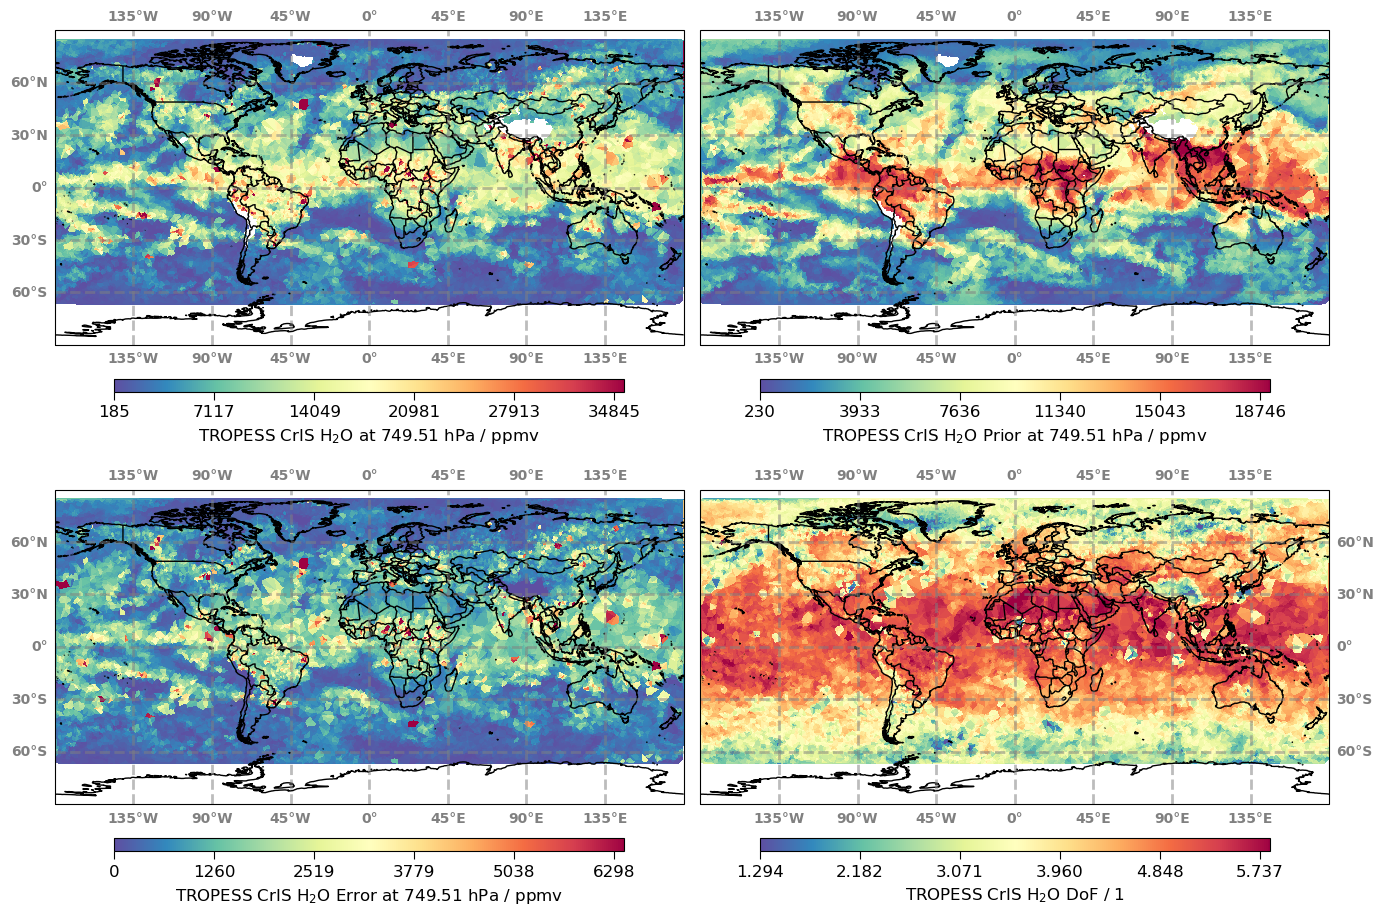

In [18]:
# Set up figure dimensions
fig = plt.figure(figsize=(14, 14))

# Loop through pressure subset values
for i_plot in range(1, 5):

    # Define some plotting variables
    if i_plot == 1:
        var = x_valid[:, p_index] * 1e6
        cbar_label = 'TROPESS CrIS H$_2$O at '+str(np.round(np.nanmean(p_valid, axis=0)[p_index], 2))+' hPa / ppmv'
    if i_plot == 2:
        var = xa_valid[:, p_index] * 1e6
        cbar_label = 'TROPESS CrIS H$_2$O Prior at '+str(np.round(np.nanmean(p_valid, axis=0)[p_index], 2))+' hPa / ppmv'
    if i_plot == 3:
        var = x_error_valid[:, p_index] * 1e6
        cbar_label = 'TROPESS CrIS H$_2$O Error at '+str(np.round(np.nanmean(p_valid, axis=0)[p_index], 2))+' hPa / ppmv'
    if i_plot == 4:
        var = dof[:]
        cbar_label = 'TROPESS CrIS H$_2$O DoF / 1'
    lon = h2o_lon
    lat = h2o_lat
    boundaries = np.linspace(np.nanpercentile(var, 1),np.nanpercentile(var, 99),256)
    cmap = matplotlib.cm.Spectral_r
    
    # Set up the plot axis for each subplot, including the projection
    ax = plt.subplot(2,2,i_plot, projection = ccrs.PlateCarree())
    
    # Define normalization
    norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    
    # Plot data
    sm = plt.tripcolor(lon, lat, var, cmap=cmap, norm=norm)
        
    # Add coastlines and borders
    ax.coastlines('50m')
    ax.add_feature(cfeature.BORDERS)
    
    # Define the extent
    ax.set_extent([-180, 180, -90, 90])
    
    # Plot gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.52, linestyle='--')
    gl.bottom_labels = True
    gl.top_labels = True
    if i_plot == 1:
        gl.left_labels = True
        gl.right_labels = False
    if i_plot == 2:
        gl.left_labels = False
        gl.right_labels = False
    if i_plot == 3:
        gl.left_labels = True
        gl.right_labels = False
    if i_plot == 4:
        gl.left_labels = False
        gl.right_labels = True
    gl.xlocator = matplotlib.ticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135])
    gl.ylocator = matplotlib.ticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold'}
    
    # Colorbar
    cbar = plt.colorbar(sm,
                        ticks=boundaries[::50],
                        fraction=0.015,
                        pad=0.04,
                        orientation='horizontal',
                        aspect=40,
                        boundaries=boundaries)
    cbar.ax.minorticks_off()
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, rotation=0, labelpad=5, fontsize=12)

# Play around with the spacing
plt.tight_layout (h_pad=-15., w_pad=1.)

# Finish the plot
plt.show()
plt.close()

## Plot profiles from Standard HDO data

Let's produce a figure with:
- a single, hand-picked profile of H$_2$O,
- global profile statistics,
- and all profiles within a lat/lon box (CONUS)

In [19]:
index = 99

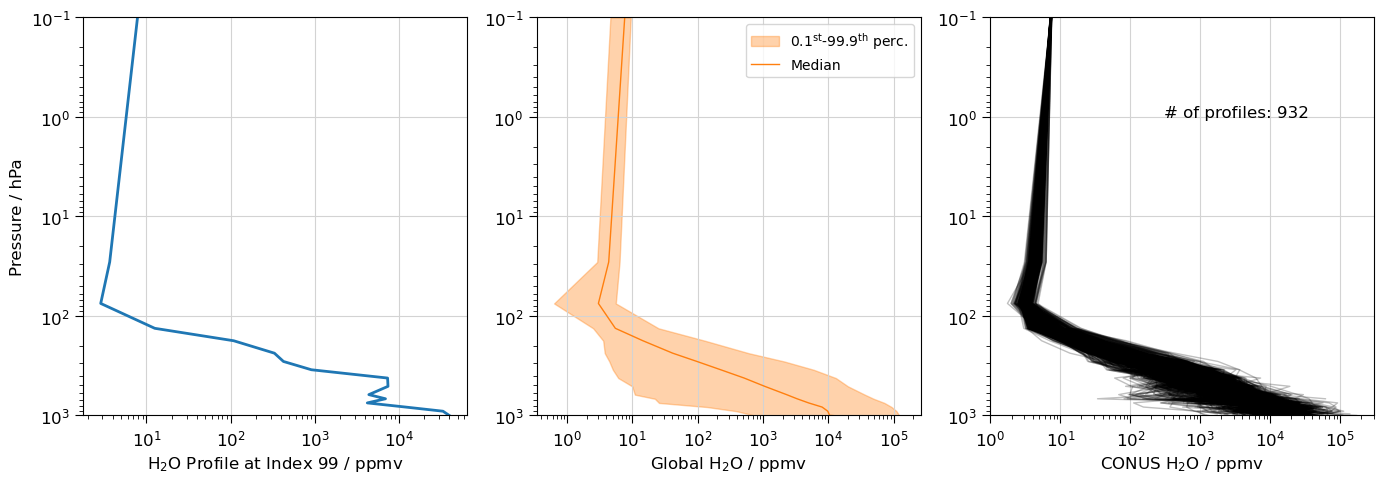

In [20]:
# Set up figure dimensions
fig = plt.figure(figsize=(14, 5))




# Set up the plot axis for the first subplot
ax = plt.subplot(1,3,1)

# Plot our example profiles
plt.plot(x_valid[index]*1e6, p_valid[index], color='tab:blue')

# Add grid lines
plt.grid(True)

# Play around with axis
plt.ylim(1000,1e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('H$_2$O Profile at Index '+str(index)+' / ppmv')
plt.ylabel('Pressure / hPa')




# Set up the plot axis for the second subplot
ax = plt.subplot(1,3,2)

# Plot our example profiles
plt.fill_betweenx(p_valid[index], np.nanpercentile(x_valid*1e6, 0.1, axis=0), np.nanpercentile(x_valid*1e6, 99.9, axis=0), color='tab:orange', alpha=0.35, label='0.1$^\\mathrm{st}$-99.9$^\\mathrm{th}$ perc.')
plt.plot(np.nanpercentile(x_valid*1e6, 50, axis=0), p_valid[index], color='tab:orange', linewidth=1, label='Median')

# Add grid lines
plt.grid(True)
plt.legend(loc='upper right', fontsize=10)

# Play around with axis
plt.ylim(1000,1e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Global H$_2$O / ppmv')
#plt.ylabel('Pressure / hPa')




# Set up the plot axis for the third subplot
ax = plt.subplot(1,3,3)

# find the CONUS profiles
ind_conus = np.where((h2o_lon>=-125)&
                     (h2o_lon<-67)&
                     (h2o_lat>=24)&
                     (h2o_lat<49)
                    )[0]

# Plot our example profiles
for i in range(0, len(ind_conus)):
    plt.plot(x_valid[ind_conus[i],:]*1e6, p_valid[ind_conus[i],:], color='black', alpha=0.25, linewidth=1)

# Add grid lines
plt.grid(True)

# Play around with axis
plt.ylim(1000,1e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('CONUS H$_2$O / ppmv')
#plt.ylabel('Pressure / hPa')
dummy = plt.xlim()
plt.text(dummy[0]+0.001*(dummy[1]-dummy[0]), 1, '# of profiles: '+str(len(ind_conus)))





# Play around with the spacing
plt.tight_layout (h_pad=-15., w_pad=1.)

# Finish the plot
plt.show()
plt.close()